# prototypes

In [2]:
import random
from datasets import load_dataset
from transformers import AutoTokenizer
from PIL import Image

# Load dataset
ds = load_dataset("deepcopy/MathWriting-Human")

def resize_image(example, size=(224, 224)):
    example["image"] = example["image"].resize(size)
    return example

ds["train"] = ds["train"].map(resize_image, num_proc=12)
ds["val"] = ds["val"].map(resize_image, num_proc=12)
ds["test"] = ds["test"].map(resize_image, num_proc=12)
latex_pool = ds["train"]["latex"]

def add_binary_label(example, latex_list):
    if random.random() > 0.5:
        example["label"] = 1
        example["latex_used"] = example["latex"]
    else:
        wrong_latex = random.choice(latex_list)
        while wrong_latex == example["latex"]:
            wrong_latex = random.choice(latex_list)
        example["label"] = 0
        example["latex_used"] = wrong_latex
    return example

# Parallel label map
ds["train"] = ds["train"].map(lambda x: add_binary_label(x, latex_pool), num_proc=12)
ds["val"] = ds["val"].map(lambda x: add_binary_label(x, latex_pool), num_proc=12)
ds["test"] = ds["test"].map(lambda x: add_binary_label(x, latex_pool), num_proc=12)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

def tokenize_latex(example):
    tokens = tokenizer(example["latex_used"], truncation=True, padding="max_length", max_length=64)
    example["latex_ids"] = tokens["input_ids"]
    return example

ds["train"] = ds["train"].map(tokenize_latex, num_proc=12)
ds["val"] = ds["val"].map(tokenize_latex, num_proc=12)
ds["test"] = ds["test"].map(tokenize_latex, num_proc=12)

tf_train = ds["train"].to_tf_dataset(
    columns=["image", "latex_ids"],
    label_cols=["label"],
    shuffle=True,
    batch_size=256
)

tf_val = ds["val"].to_tf_dataset(
    columns=["image", "latex_ids"],
    label_cols=["label"],
    shuffle=False,
    batch_size=256
)

tf_test = ds["test"].to_tf_dataset(
    columns=["image", "latex_ids"],
    label_cols=["label"],
    shuffle=False,
    batch_size=256
)

Map (num_proc=12): 100%|██████████| 7644/7644 [00:00<00:00, 8590.11 examples/s] 
2025-07-12 21:17:12.511338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752355032.531814    4192 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752355032.538262    4192 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752355032.557314    4192 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752355032.557342    4192 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 

In [6]:
# Check datset
print(ds)
print(ds.keys())

DatasetDict({
    train: Dataset({
        features: ['image', 'latex', 'sample_id', 'split_tag', 'data_type', 'label', 'latex_used', 'latex_ids'],
        num_rows: 229864
    })
    test: Dataset({
        features: ['image', 'latex', 'sample_id', 'split_tag', 'data_type', 'label', 'latex_used', 'latex_ids'],
        num_rows: 7644
    })
    val: Dataset({
        features: ['image', 'latex', 'sample_id', 'split_tag', 'data_type', 'label', 'latex_used', 'latex_ids'],
        num_rows: 15674
    })
})
dict_keys(['train', 'test', 'val'])


In [8]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

os.environ["TF_DETERMINISTIC_OPS"] = "1"
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

img_input = keras.Input(shape=(224, 224, 3), name="image", dtype="float32")
x_img = layers.Rescaling(1.0 / 255)(img_input)
x_img = layers.Conv2D(32, 3, activation="relu")(x_img)
x_img = layers.MaxPooling2D()(x_img)
x_img = layers.Conv2D(64, 3, activation="relu")(x_img)
x_img = layers.GlobalAveragePooling2D()(x_img)

txt_input = keras.Input(shape=(64,), name="latex_ids", dtype="int32")
x_txt = layers.Embedding(input_dim=50257, output_dim=32)(txt_input)
x_txt = layers.GlobalAveragePooling1D()(x_txt)

x = layers.Concatenate()([x_img, x_txt])
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=[img_input, txt_input], outputs=output, name="version-cv")
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

tf_train = ds["train"].to_tf_dataset(
    columns=["image", "latex_ids"],
    label_cols=["label"],
    shuffle=True,
    batch_size=256
)

# Run with tf_val for model validation during training
#model.fit(tf_train, validation_data=tf_val, epochs=3)
model.fit(tf_train, epochs=3)

Model: "version-cv"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ image[0][0]       │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 222, 222,  │        896 │ rescaling_3[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 111, 111,  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latex_ids           │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 64, 32)    │  1,608,224 │ latex_ids[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv2d_7[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ embedding_3[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 96)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     12,416 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,640,161 (6.26 MB)

 Trainable params: 1,640,161 (6.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
897/898 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4985 - loss: 0.6934

E0000 00:00:1752357360.968581    5016 buffer_comparator.cc:156] Difference at 0: 2.88244e+06, expected 2.48897e+06
E0000 00:00:1752357360.968637    5016 buffer_comparator.cc:156] Difference at 1: 2.88261e+06, expected 2.4892e+06
E0000 00:00:1752357360.968648    5016 buffer_comparator.cc:156] Difference at 2: 2.88266e+06, expected 2.48938e+06
E0000 00:00:1752357360.968657    5016 buffer_comparator.cc:156] Difference at 3: 2.88213e+06, expected 2.48865e+06
E0000 00:00:1752357360.968678    5016 buffer_comparator.cc:156] Difference at 4: 2.88245e+06, expected 2.48901e+06
E0000 00:00:1752357360.968692    5016 buffer_comparator.cc:156] Difference at 5: 2.88259e+06, expected 2.48921e+06
E0000 00:00:1752357360.968703    5016 buffer_comparator.cc:156] Difference at 6: 2.88246e+06, expected 2.48903e+06
E0000 00:00:1752357360.968716    5016 buffer_comparator.cc:156] Difference at 7: 2.88263e+06, expected 2.4891e+06
E0000 00:00:1752357360.968729    5016 buffer_comparator.cc:156] Difference at 8: 2

898/898 ━━━━━━━━━━━━━━━━━━━━ 1064s 1s/step - accuracy: 0.4985 - loss: 0.6934
Epoch 2/3
898/898 ━━━━━━━━━━━━━━━━━━━━ 1041s 1s/step - accuracy: 0.5866 - loss: 0.6558
Epoch 3/3
898/898 ━━━━━━━━━━━━━━━━━━━━ 1040s 1s/step - accuracy: 0.7422 - loss: 0.5191


In [9]:
model.save("version-cv.keras")

In [10]:
tf_test = ds["test"].to_tf_dataset(
    columns=["image", "latex_ids"],
    label_cols=["label"],
    shuffle=True,
    batch_size=16
)

tf_val = ds["val"].to_tf_dataset(
    columns=["image", "latex_ids"],
    label_cols=["label"],
    shuffle=False,
    batch_size=16
)

In [13]:
# Evals
results = model.evaluate(tf_test)
print("Test loss:", results[0])
print("Test accuracy:", results[1])

478/478 ━━━━━━━━━━━━━━━━━━━━ 31s 64ms/step - accuracy: 0.7600 - loss: 0.4912
Test loss: 0.4926668703556061
Test accuracy: 0.7607273459434509


In [12]:
# Validate
val_results = model.evaluate(tf_val)
print("Validation loss:", val_results[0])
print("Validation accuracy:", val_results[1])

980/980 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.7801 - loss: 0.4707
Validation loss: 0.47107386589050293
Validation accuracy: 0.781230092048645


In [14]:
# Predict
preds = model.predict(tf_test)
print(preds[:5])

478/478 ━━━━━━━━━━━━━━━━━━━━ 31s 64ms/step
[[0.17124136]
 [0.70075417]
 [0.7873443 ]
 [0.8379745 ]
 [0.04374632]]


In [18]:
#!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [20]:
from tqdm import tqdm

y_true = []
y_pred = []

for inputs, labels in tqdm(tf_test, desc="Predicting"):
    images = inputs["image"]
    latex_ids = inputs["latex_ids"]
    y_true_batch = labels.numpy()
    preds = model.predict({"image": images, "latex_ids": latex_ids}, verbose=0)
    preds_binary = (preds.flatten() > 0.5).astype(int)
    y_true.extend(y_true_batch)
    y_pred.extend(preds_binary)

Predicting: 100%|██████████| 478/478 [00:59<00:00,  8.09it/s]


In [24]:
from sklearn.metrics import classification_report, f1_score

print(classification_report(y_true, y_pred, digits=4))
f1 = f1_score(y_true, y_pred)
print("F1 Score:", f1)

              precision    recall  f1-score   support

           0     0.8352    0.6465    0.7288      3802
           1     0.7141    0.8738    0.7859      3842

    accuracy                         0.7607      7644
   macro avg     0.7747    0.7601    0.7574      7644
weighted avg     0.7743    0.7607    0.7575      7644

F1 Score: 0.7859065901907994


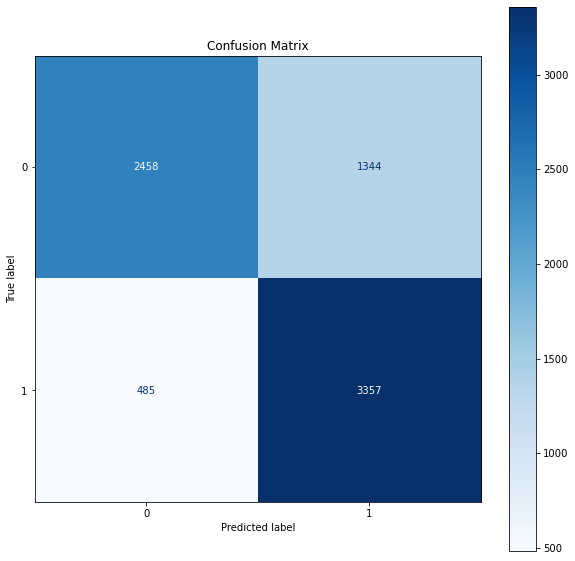

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

plt.figure(figsize=(10, 10))  
disp.plot(cmap="Blues", ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

In [25]:
y_probs = []

for inputs, labels in tqdm(tf_test, desc="Predicting Probs"):
    images = inputs["image"]
    latex_ids = inputs["latex_ids"]
    preds = model.predict({"image": images, "latex_ids": latex_ids}, verbose=0)
    y_probs.extend(preds.flatten())

Predicting Probs: 100%|██████████| 478/478 [00:59<00:00,  8.01it/s]


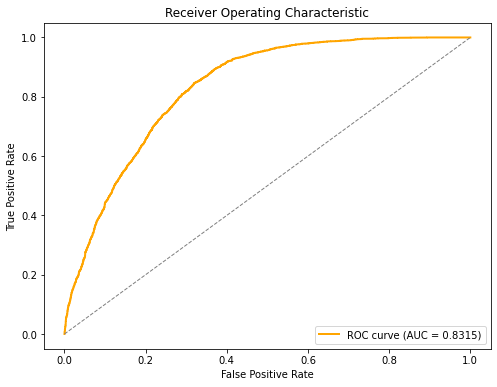

In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="orange", lw=2, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [41]:
original_test_iter = iter(ds["test"])

LaTeX string from dataset: 0<sinx<x
Decoded LaTeX from tokens: \sqrt[4]{3^{3}e^{\pi}}
True label: 0
Predicted label: 0


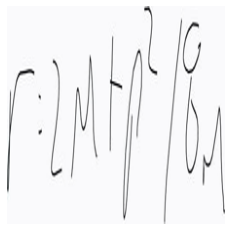

LaTeX string from dataset: \langle a,\sqrt{2}\rangle
Decoded LaTeX from tokens: \rho\frac{Dv}{Dt}=\nabla\cdot\sigma+f
True label: 1
Predicted label: 1


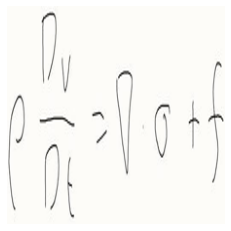

LaTeX string from dataset: X[(p+m)\Delta_{F}]
Decoded LaTeX from tokens: \lambda(\cdot;t^{\prime})
True label: 0
Predicted label: 1


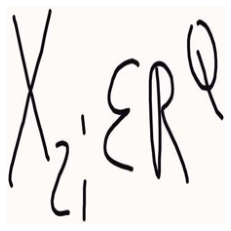

LaTeX string from dataset: \sqrt{a+b\sqrt{c}}
Decoded LaTeX from tokens: lim_{t\rightarrow0^{+}}f(t)^{g(t)}=1
True label: 1
Predicted label: 1


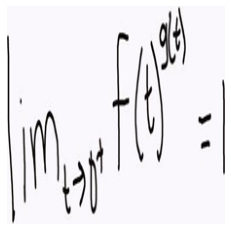

LaTeX string from dataset: K_{x}Na_{1-x}Cl
Decoded LaTeX from tokens: [\Delta(x)p_{1^{(n)}}]_{l_{1},\cdot\cdot\cdot,l_{k}}
True label: 0
Predicted label: 0


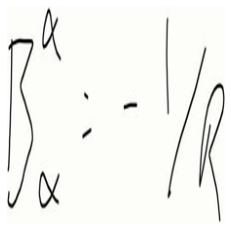

LaTeX string from dataset: A=[\begin{matrix}1&1\\ 1&1\end{matrix}]
Decoded LaTeX from tokens: \lambda=\sum_{j}m_{j}deg(f_{j})
True label: 1
Predicted label: 1


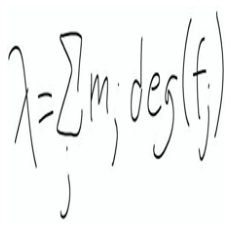

LaTeX string from dataset: (0,0,\pm\sqrt{3},\pm1)
Decoded LaTeX from tokens: \frac{dS}{dt}=\dot{S}_{i}
True label: 1
Predicted label: 0


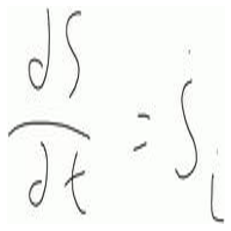

LaTeX string from dataset: \frac{I}{I_{0}}=\frac{p^{2}}{p_{0}^{2}}
Decoded LaTeX from tokens: x_{k\beta}+\lambda_{k}\frac{\partial\sigma_{k}(t)}{\partial x_{k\beta}}
True label: 0
Predicted label: 0


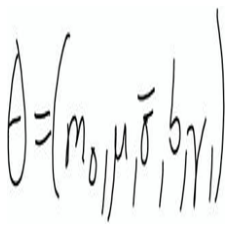

LaTeX string from dataset: a_{1}\in[1,4,7,...]
Decoded LaTeX from tokens: E(sup_{T>t}W_{T}/T)
True label: 1
Predicted label: 1


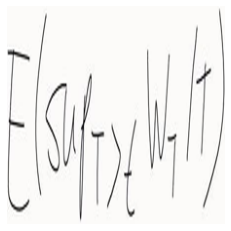

LaTeX string from dataset: -\frac{\partial H_{z}}{\partial x}=\epsilon\frac{\partial E_{y}}{\partial t}
Decoded LaTeX from tokens: f(x)=\frac{2(x+1)}{x+1}
True label: 0
Predicted label: 1


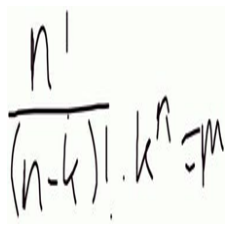

LaTeX string from dataset: (\frac{(210+4)}{9})^{\frac{(7-57)}{9}}
Decoded LaTeX from tokens: T_{j_{1}...j_{q}}^{i_{1}...i_{p}}[f]
True label: 1
Predicted label: 1


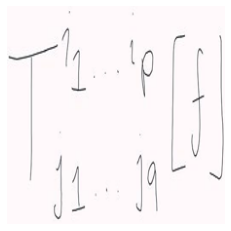

LaTeX string from dataset: \psi_{1}(\psi_{1}(0))=\epsilon_{\epsilon_{\Omega+1}}
Decoded LaTeX from tokens: Z_{i}^{(m)}=mY_{i}^{(m)}
True label: 1
Predicted label: 1


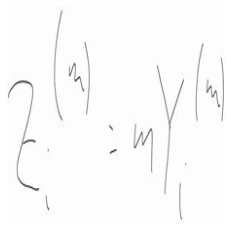

LaTeX string from dataset: lim_{z\rightarrow z_{0}}f(z)=f(z_{0})
Decoded LaTeX from tokens: \hat{p}=1
True label: 0
Predicted label: 0


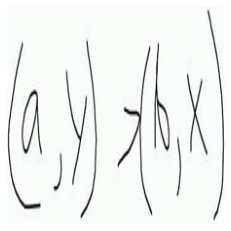

LaTeX string from dataset: lim_{\Delta x\rightarrow0}g(\Delta x)=0
Decoded LaTeX from tokens: \frac{1}{2}cT
True label: 0
Predicted label: 0


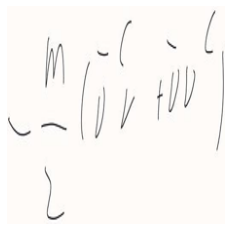

LaTeX string from dataset: (\begin{matrix}\alpha&0\\ \beta&\alpha^{-1}\end{matrix})
Decoded LaTeX from tokens: \int_{0}^{t}e^{As}Bu(s)ds
True label: 1
Predicted label: 1


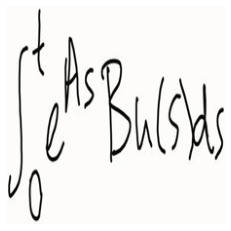

LaTeX string from dataset: -\frac{1}{3}
Decoded LaTeX from tokens: 0+0=0
True label: 1
Predicted label: 1


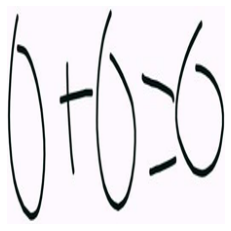

In [43]:
import matplotlib.pyplot as plt

for inputs, labels in tf_test.take(1):  # Adjust to however many batches you want
    images = inputs["image"]
    latex_ids_batch = inputs["latex_ids"]
    true_labels = labels.numpy()
    preds = model.predict({"image": images, "latex_ids": latex_ids_batch}, verbose=0)
    preds_binary = (preds.flatten() > 0.5).astype(int)

    for i in range(images.shape[0]):
        # Get original example from the iterator
        original_example = next(original_test_iter)

        print("LaTeX string from dataset:", original_example["latex_used"])
        print("Decoded LaTeX from tokens:", tokenizer.decode(latex_ids_batch[i].numpy(), skip_special_tokens=True))
        print("True label:", true_labels[i])
        print("Predicted label:", preds_binary[i])
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.show()

In [44]:
latex_ids_batch = inputs["latex_ids"]

In [47]:
decoded_texts = [tokenizer.decode(latex_ids_batch[j].numpy(), skip_special_tokens=True) for j in range(latex_ids_batch.shape[0])]
for idx, text in enumerate(decoded_texts):
    print(f"Decoded LaTeX string {idx}: {text}")

Decoded LaTeX string 0: \sqrt[4]{3^{3}e^{\pi}}
Decoded LaTeX string 1: \rho\frac{Dv}{Dt}=\nabla\cdot\sigma+f
Decoded LaTeX string 2: \lambda(\cdot;t^{\prime})
Decoded LaTeX string 3: lim_{t\rightarrow0^{+}}f(t)^{g(t)}=1
Decoded LaTeX string 4: [\Delta(x)p_{1^{(n)}}]_{l_{1},\cdot\cdot\cdot,l_{k}}
Decoded LaTeX string 5: \lambda=\sum_{j}m_{j}deg(f_{j})
Decoded LaTeX string 6: \frac{dS}{dt}=\dot{S}_{i}
Decoded LaTeX string 7: x_{k\beta}+\lambda_{k}\frac{\partial\sigma_{k}(t)}{\partial x_{k\beta}}
Decoded LaTeX string 8: E(sup_{T>t}W_{T}/T)
Decoded LaTeX string 9: f(x)=\frac{2(x+1)}{x+1}
Decoded LaTeX string 10: T_{j_{1}...j_{q}}^{i_{1}...i_{p}}[f]
Decoded LaTeX string 11: Z_{i}^{(m)}=mY_{i}^{(m)}
Decoded LaTeX string 12: \hat{p}=1
Decoded LaTeX string 13: \frac{1}{2}cT
Decoded LaTeX string 14: \int_{0}^{t}e^{As}Bu(s)ds
Decoded LaTeX string 15: 0+0=0


In [ ]:
# End of prototype and test build